In [10]:
#!pip install opencv-python, scikit-image, scipy, pandas, matplotlib, scikit-learn, scikit-learn-intelex

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import chan_vese, active_contour, watershed
from skimage.morphology import erosion, dilation, opening, closing, disk, remove_small_objects
from skimage.measure import label
from skimage import io, color, filters
from scipy import ndimage as ndi
import os
import warnings
warnings.filterwarnings('ignore')

In [12]:
base_dir = r'/kaggle/input/d/tensura3607/cell-counting-roboflow-segmentation-masks/test/images'
image_path = base_dir + '/Screenshot-2024-08-20-at-3-40-57-PM_png.rf.51490a3f822ef799797a83f5462ccc9a.jpg'

Image size: (640, 640, 3)
Data type: uint8
Pixel min/max value: 121/236


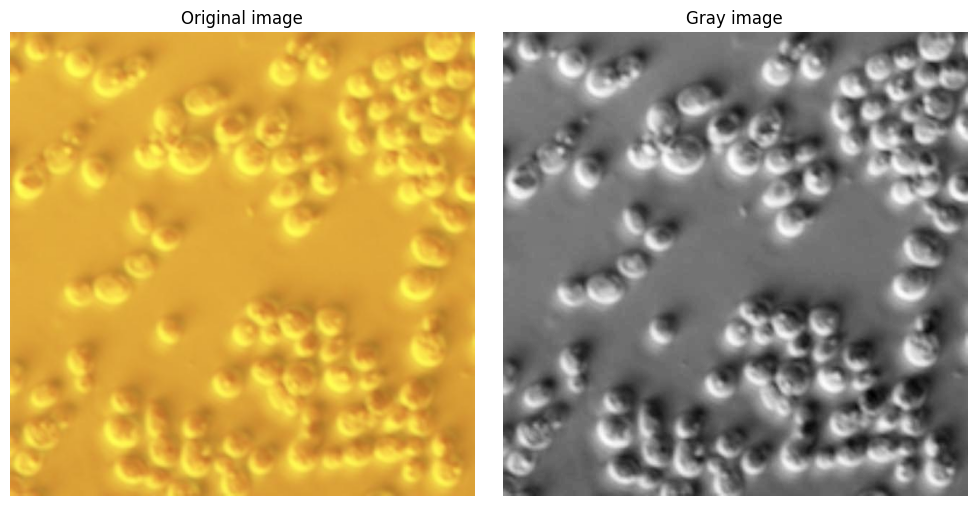

Testing on image: /kaggle/input/d/tensura3607/cell-counting-roboflow-segmentation-masks/test/images/Screenshot-2024-08-20-at-3-40-57-PM_png.rf.51490a3f822ef799797a83f5462ccc9a.jpg


In [13]:
image_bgr = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

print(f"Image size: {image_bgr.shape}")
print(f"Data type: {image_bgr.dtype}")
print(f"Pixel min/max value: {gray.min()}/{gray.max()}")

# Show original image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title(f"Original image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(gray, cmap='gray')
plt.title('Gray image')
plt.axis('off')
plt.tight_layout()
plt.show()

print(f"Testing on image: {image_path}")

# ----------------------------------------------------------------
# 1. PREPROCESSING
# ----------------------------------------------------------------

In [14]:
def preprocess_image(image_path):
    """
    Image preprocessing functions:
    1. Read the image and convert it to grayscale.
    2. Apply Gaussian Blur filter to reduce noise.
    3. Apply Sharpen filter to sharpen edges.
    4. Apply derivative operator (Sobel) to detect edges.

    Args:
    image_path (str): Path to image file.

    Returns:
    numpy.ndarray: Image has been processed and converted to binary.
    """
    # Read grayscale image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    
    # Step 1: Light Gaussian Blur
    blurred_img = cv2.GaussianBlur(img, (5, 5), 0)
    
    # Step 2: Sharpen
    sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
    ])
    sharpened_img = cv2.filter2D(blurred_img, -1, sharpen_kernel)
    
    # Step 3: Derivative operator (Sobel) to calculate gradient
    grad_x = cv2.Sobel(sharpened_img, cv2.CV_64F, 1, 0, ksize=3) 
    grad_y = cv2.Sobel(sharpened_img, cv2.CV_64F, 0, 1, ksize=3) 
    sobel_img = cv2.magnitude(grad_x, grad_y).astype(np.uint8) 
    
    # Step 4: Segmentation using Otsu threshold 
    #_, processed_image = cv2.threshold(sobel_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) 
    _, processed_image = cv2.threshold(sobel_img, 0, 255, cv2.THRESH_OTSU) 
    
    return processed_image

# ----------------------------------------------------------------
# 2. SEGMENTATION METHODS
# ----------------------------------------------------------------

In [15]:
def segmentation_methods(image, method="otsu", init_radius=30, min_area=50):
    if method == "otsu":
        if len(image.shape) == 3: 
            gray = color.rgb2gray(image) 
        else: 
            gray = image 
        # Otsu thresholding 
        threshold_val = filters.threshold_otsu(gray) 
        binary_result = gray > threshold_val 
        # Convert back to uint8 binary image 
        binary_result = binary_result.astype(np.uint8) * 255 
        
        # Morphological closing for smoothing 
        selem = disk(2) 
        binary_bool = binary_result > 0 
        closed = closing(binary_bool, selem) 
        binary_result = (closed * 255).astype(np.uint8)
        
    elif method == "adaptive":
        if len(image.shape) == 3: 
            gray = color.rgb2gray(image) 
        else: 
            gray = image 
        # Adaptive thresholding using local mean 
        threshold_val = filters.threshold_local(gray, block_size=35, offset=0.01) 
        binary_result = gray > threshold_val 
        
        # Convert back to uint8 binary image 
        binary_result = binary_result.astype(np.uint8) * 255 
        
        # Morphological closing for smoothing 
        selem = disk(2) 
        binary_bool = binary_result > 0 
        closed = closing(binary_bool, selem) 
        binary_result = (closed * 255).astype(np.uint8)
                
    elif method == "watershed":  
        if len(image.shape) == 3:
            img_gray = color.rgb2gray(image)
        else:
            img_gray = image

        # Create opening to reduce noise
        selem = disk(1)
        opening_result = opening(img_gray > 0, selem)

        # Sure background
        sure_bg = dilation(opening_result, disk(2))

        # Distance transform
        dist_transform = ndi.distance_transform_edt(opening_result)

        # Find sure foreground
        threshold_val = 0.1 * dist_transform.max()
        sure_fg = dist_transform > threshold_val

        # Unknown region
        unknown = sure_bg.astype(bool) ^ sure_fg.astype(bool)

        # Markers
        markers = label(sure_fg)
        markers = markers + 1
        markers[unknown] = 0

        # Watershed trên negative distance
        labels = watershed(-dist_transform, markers, mask=sure_bg, connectivity=8)

        # Create binary image from labels
        binary_result = np.zeros_like(img_gray, dtype=np.uint8)
        
        # Filter regions with large enough area
        for region_label in np.unique(labels):
            if region_label <= 1:  # Ignore background and boundary
                continue
                
            region_mask = (labels == region_label).astype(np.uint8)
            
            if min_area > 0:
                area = np.sum(region_mask)
                if area < min_area:
                    continue
            
            region_mask = closing(region_mask.astype(bool), disk(1)).astype(np.uint8)
            region_mask *= 255
            
            binary_result = np.maximum(binary_result, region_mask)
            
    elif method == "chanvese":
        # Chan-Vese segmentation
        cv_result = chan_vese(
            image, 
            mu=0.075, 
            lambda1=25, 
            lambda2=35, 
            tol=1e-2, 
            max_num_iter=300, 
            init_level_set="checkerboard", 
            extended_output=True)
        
        phi = cv_result[0]
        mask = phi > 0  # binary mask
        binary_result = (mask * 255).astype("uint8")
        
    else:
        raise ValueError(f"Method '{method}' is not supported!")
    
    return binary_result.astype(np.uint8)

# ----------------------------------------------------------------
# 3. COUNT AND DRAW FUNCTION
# ----------------------------------------------------------------

In [16]:
def count_and_draw(binary_image, original_image_path, method_name="Segmentation", min_area=50):
        if binary_image.dtype == np.uint8:
            mask = binary_image > 0
        else:
            mask = binary_image.astype(bool)
    
        # Remove small objects (min_area in pixels)
        if min_area is not None and min_area > 0:
            cleaned_mask = remove_small_objects(mask, min_size=int(min_area))
        else:
            cleaned_mask = mask
    
        # Convert to uint8 0/255 for OpenCV
        cleaned_uint8 = (cleaned_mask.astype(np.uint8) * 255)
        
        # Find contours on cleaned image
        contours, _ = cv2.findContours(cleaned_uint8.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Filter contours by minimum area (add 1 guard row)
        valid_contours = [c for c in contours if cv2.contourArea(c) >= min_area]
        
        num_objects = len(valid_contours)
        
        # Prepare image for drawing
        img_color = None
        if original_image_path is not None:
            img_color = cv2.imread(original_image_path)
            image_rgb = cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)
            if img_color is None:
                raise FileNotFoundError(f"Image not found: {original_image_path}")
    
        if img_color is None:
            h, w = cleaned_uint8.shape[:2]
            img_color = 255 * np.ones((h, w, 3), dtype=np.uint8)
    
        # Draw contours on the image (green) 
        cv2.drawContours(img_color, valid_contours, -1, (255, 0, 0), 2) 
        
        # Display using matplotlib 
        plt.figure(figsize=(15, 5)) 
        
        plt.subplot(1, 3, 1) 
        plt.imshow(image_rgb) 
        plt.title(f"Original photo") 
        plt.axis("off") 
        
        plt.subplot(1, 3, 2) 
        plt.imshow(cleaned_uint8, cmap='gray') 
        plt.title(f'{method_name} - Cleaned Binary (min_area={min_area})') 
        plt.axis('off') 
        
        plt.subplot(1, 3, 3) 
        plt.imshow(cv2.cvtColor(img_color, cv2.COLOR_BGR2RGB)) 
        plt.title(f'{method_name} - Objects Detected: {num_objects}') 
        plt.axis('off') 
        plt.tight_layout() 
        plt.show()
    
        return num_objects, valid_contours, cleaned_uint8

In [17]:
def running_function(image_path, method="chanvese"):
    # Step 1: Preprocessing
    processed_image = preprocess_image(image_path)
    
    # Step 2: Segmentation
    segmented_binary = segmentation_methods(processed_image, method)
    
    # Step 3: Count and draw
    method_names = {
        "chanvese": "Chan-Vese",
        "watershed": "Watershed",
        "otsu": "Otsu Thresholding",
        "adaptive": "Adaptive Thresholding"
    }
    
    num_objects, contours, _ = count_and_draw(
        segmented_binary, 
        image_path, 
        method_names.get(method, method)
    )
    
    print(f"[{method}] Number of objects detected: {num_objects}")
    return num_objects

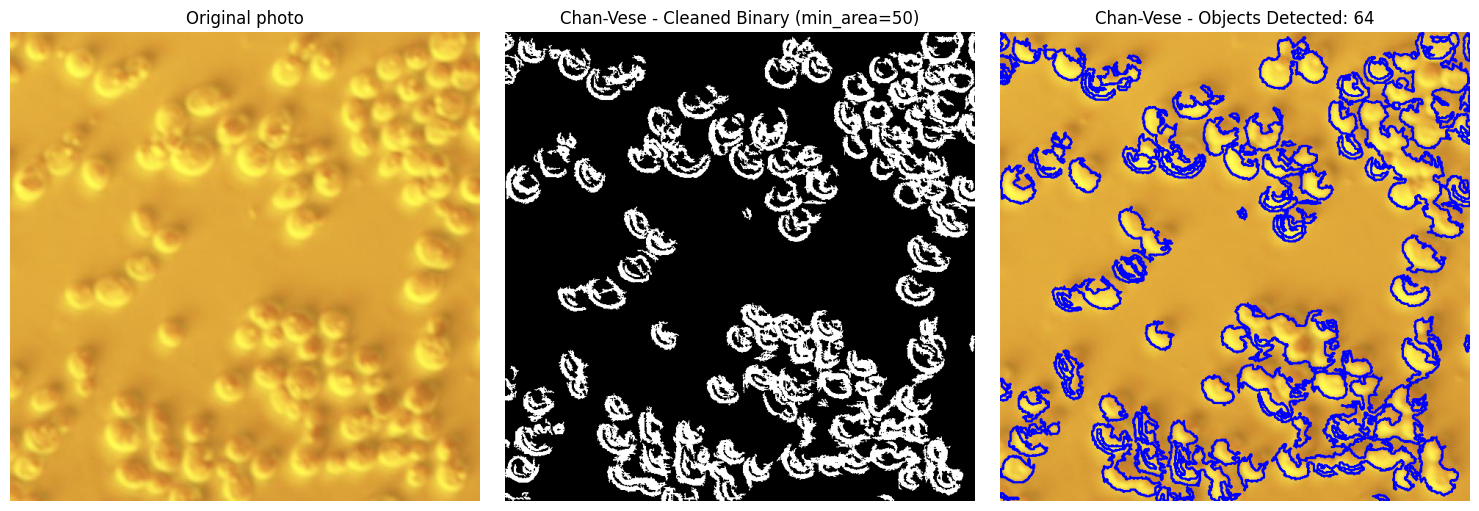

[chanvese] Number of objects detected: 64


64

In [18]:
running_function(image_path, method="chanvese")

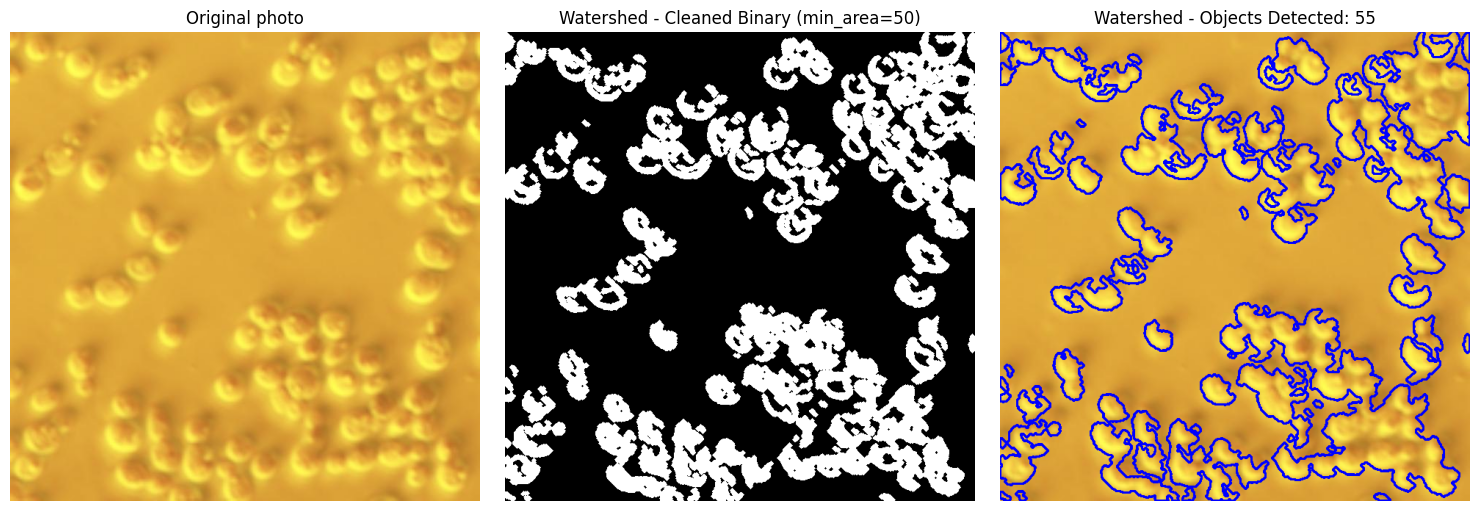

[watershed] Number of objects detected: 55


55

In [19]:
running_function(image_path, method="watershed")

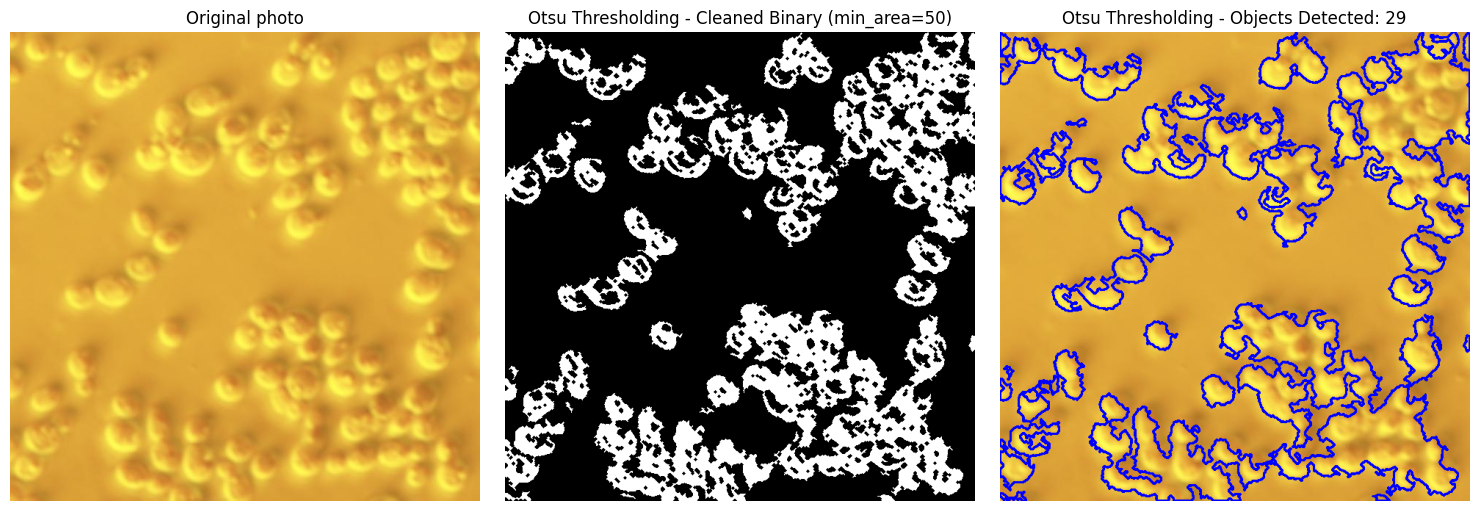

[otsu] Number of objects detected: 29


29

In [20]:
running_function(image_path, method="otsu")

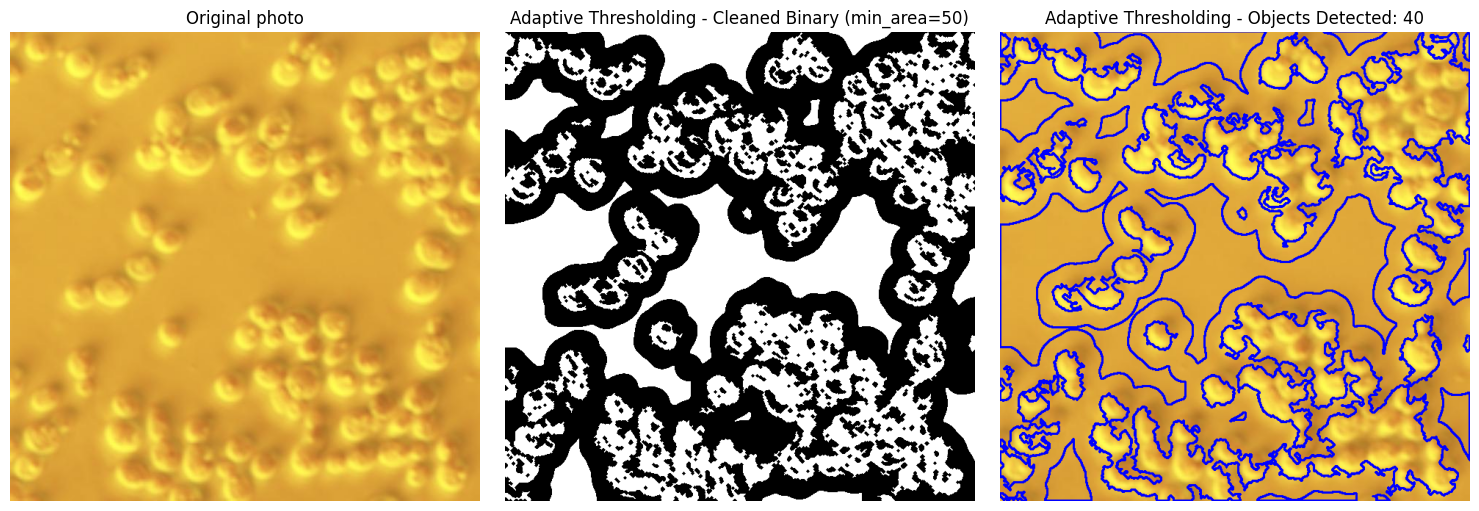

[adaptive] Number of objects detected: 40


40

In [21]:
running_function(image_path, method="adaptive")